This application takes two images as input and outputs the probablility that they are the same image.  This is the second version of the notebooks which is designed to be cleaned up and use the data loader to save RAM

## Imports

In [512]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import cv2
import os
import numpy as np
import random
from random import randrange
import math

## Settings

In [813]:
verbose = 0
negative_images_per_pos_image = 10
image_shape = (32, 32)

## Data Utils

In [814]:
'''Load an image and resize to spec'''
def load_image_to_tensor(src):
    img = image.imread(src)
    resize = cv2.resize(img, image_shape)
    tensor = torch.tensor(resize)
    # put in N Channel Height Width format!
    permute = tensor.permute(2,0,1)
    return permute

def make_input_from_images(img_a, img_b):
    cat = torch.cat((img_a, img_b), dim = 2)
    return cat

def make_input_from_paths(x):
    img_a = load_image_to_tensor(x[0])
    img_b = load_image_to_tensor(x[1])
    return make_input_from_images(img_a, img_b)

def show_example(example):
    x, y = example
    img_a = load_image_to_tensor(x[0])
    img_b = load_image_to_tensor(x[1])
    inpt = make_input_from_images(img_a, img_b)

    title = 'Positive Example' if y == 1 else 'Negative Example'
    plt.title(title)
    plt.imshow(inpt.permute(1,2,0))
    plt.show()
    
    
    


## Create Dataset

In [425]:
def remove_ds(files):
    for f in files:
        if '.DS' in f:
            files.remove(f)
    return files
            
class FaceMatchDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, negative_examples_per_image=10):
        '''generate examples based on files'''
        x = np.array([[]])
        y = np.array([])
        people_images_dict = {}
        
        # each folder contains a list of people
        people_folders = os.listdir(directory)
        people_folters = remove_ds(people_folders)
        
        for person_folder in people_folders:
            images = os.listdir(directory + '/' + person_folder)
            images = remove_ds(images)
            image_paths = [] 
            for image in images:
                    image_paths.append(directory + '/' + person_folder + '/' + image)

            people_images_dict[person_folder] = image_paths
        
        for person in people_images_dict.keys():
            # get positive images
            positive_images = people_images_dict[person]
    
            # get negative images
            people_images_dict_keys = list(people_images_dict.keys())
            people_images_dict_keys.remove(person)
            negative_images = []

            for k in people_images_dict_keys:
                negative_images = negative_images + people_images_dict[k]
                
            #for each image
            for first_pos_image in positive_images:

                #make positive examples
                for second_pos_image in positive_images:
                    
                    positive_example = np.array([[first_pos_image, second_pos_image]])
                    if (x.size == 0):
                        x = positive_example
                    else:
                        x = np.append(x, positive_example, axis=0)
                    y = np.concatenate((y, [1]))
            
                #make negative examples
                for i in range(negative_examples_per_image):
                    random_negative_image_filename = negative_images[randrange(len(negative_images))]
                    if randrange(3) == 0:
                        negative_example = np.array([[random_negative_image_filename, first_pos_image]])
                        x = np.append(x, negative_example, axis=0)
                        y = np.concatenate((y, [0]))
                    else:
                        negative_example = np.array([[first_pos_image, random_negative_image_filename]])
                        x = np.append(x, negative_example, axis=0)
                        y = np.concatenate((y, [0]))
            
        
        self.x = x
        self.y = y
        
    
    def __len__(self):
        #return the number of examples
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        #make the example for the index
        idx_x = make_input_from_paths(self.x[idx])
        idx_y = torch.Tensor([self.y[idx]])
        
        return idx_x.float(), idx_y.float()
    
    def get_x_length(self):
        return self.x.shape[0]
    
    def get_y_length(self):
        return self.y.shape[0]
    

In [426]:
train_dataset = FaceMatchDataset('TrainCroppedDataset', negative_examples_per_image=negative_images_per_pos_image)
test_dataset = FaceMatchDataset('TestCroppedDataset', negative_examples_per_image=negative_images_per_pos_image)


In [387]:
print(train_dataset.get_x_length())
print(train_dataset.get_y_length())
# print(train_dataset.__getitem__(5310))
# print(test_dataset.__getitem__(20))


6540
6540


## Network Utils

In [722]:
def show_example_with_prediction(example):
    x, y = example
#     img_a = load_image_to_tensor(x[0])
#     img_b = load_image_to_tensor(x[1])
#     inpt = make_input_from_images(img_a, img_b)

    net_inpt = torch.unsqueeze(x, 0)
    pred = model(net_inpt.float())

    print('\033[92mCorrect!\033[0m' if round(pred.detach().numpy()[0][0]) == y else '\033[93mWrong!\033[0m')
    print(('Positive Example' if y == 1 else 'Negative Example') + ' Prediction: ' + str(pred.detach().numpy()[0][0]))
    
    plt.imshow(x.permute(1,2,0).int())
    plt.show()

## Create Network

In [816]:
'''The Network! Pretty Self Explanatory'''
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.a1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        #norm???
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.a2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 4)
        # layer 3
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.a3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 4)
        #linear
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 64, out_features = 32)
        self.a4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features = 32, out_features = 1)
        self.a5 = nn.ReLU()
    

    def forward(self, x):
        # layer 1
        if verbose == 1: print(x.shape)
        x = self.conv1(x)
        x = self.a1(x)
        x = self.pool1(x)
        # layer 2
        if verbose == 1: print(x.shape)
        x = self.conv2(x)
        x = self.a2(x)
        x = self.pool2(x)
        #layer 3
        if verbose == 1: print(x.shape)
        x = self.conv3(x)
        x = self.a3(x)
        x = self.pool3(x)
        #linear
        x = self.flatten(x)
        if verbose == 1: print(x.shape)
        x = self.fc1(x)
        x = self.a4(x)
        x = self.fc2(x)
#         x = torch.tanh(x)
        return(x)



### Reset Training

In [817]:
model = Net()
loss_hist = []

## Train Network

#### Train Settings

In [832]:
batch_size = 128
num_epochs = 5
learning_rate = 0.01

In [833]:
loss_hist = []
accuracy_on_train_hist = []
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay = 1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=2)

loss_function = nn.MSELoss(reduction='sum')
last_accuracy = None

#### Train Routine

-----Beginning Training-----
Current Epoch: 4 Loss: 0.12472909 Last Accuracy: 69.60244648318043%
-----Completed 5 Epochs-----


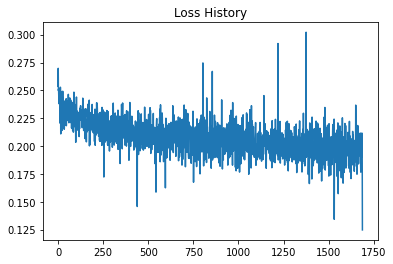

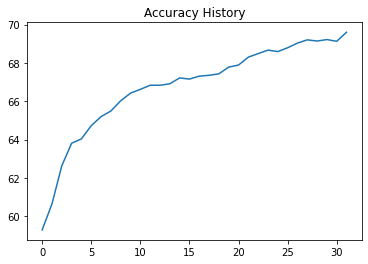

In [852]:
print('-----Beginning Training-----')
for epoch in range(num_epochs):
    
    for batch_idx, (mini_x, mini_y) in enumerate(train_loader):
        optimizer.zero_grad() # reset all optimized Tensor gradients to zero
        mini_y_hat = model(mini_x)
        #loss = F.nll_loss(mini_y_hat, mini_y) # compute loss
        loss = loss_function(mini_y_hat, mini_y)
        loss.backward() # computes gradients
        optimizer.step() # take one optimization step
        avg_loss = loss/mini_x.shape[0]
        loss_hist.append(avg_loss) #average loss
        loss_to_print = avg_loss.detach().numpy()#np.around(loss.detach().numpy(), decimals=5)
        print('Current Epoch: ' + str(epoch) + ' Loss: ' + str(loss_to_print) + ' Last Accuracy: ' + str(last_accuracy) + '%', end='\r')
    print('Current Epoch: ' + str(epoch) + ' Loss: ' + str(loss_to_print) + ' Last Accuracy: ' + 'Computing...%', end='\r')
    a, _, _ = compute_average_acuracy_for_dataset(train_dataset)
    accuracy_on_train_hist.append(a)
    last_accuracy = a
#     scheduler.step()
#         if batch_idx % 100 == 0:
#             print('Loss: ' + str(loss.detach().numpy()))
    
#     print('Completed Epoch: ' + str(epoch))
optimizer.zero_grad() # I think this should save memory
print('Current Epoch: ' + str(epoch) + ' Loss: ' + str(loss_to_print) + ' Last Accuracy: ' + str(last_accuracy) + '%', end='\r')
print('\n-----Completed ' + str(num_epochs) + ' Epochs-----')
plt.title('Loss History')
plt.plot(loss_hist[5:])
plt.show()
plt.title('Accuracy History')
plt.plot(accuracy_on_train_hist)
plt.show()


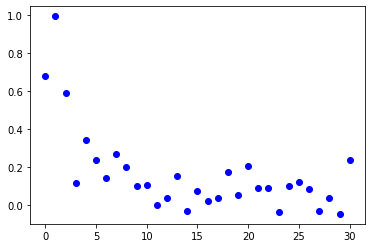

In [853]:

a_delta = []
for i in range(len(accuracy_on_train_hist)):
    if i != 0:
        n_m_o = accuracy_on_train_hist[i - 1]
        n = accuracy_on_train_hist[i]
        a_delta.append((n-n_m_o)/2)
plt.plot(a_delta, 'bo')
plt.show()

## Test Network
### Test Entire Dataset

In [862]:
def compute_average_acuracy_for_dataset(ds):
    test_loader = torch.utils.data.DataLoader(ds, batch_size=128)
    y_hat = torch.Tensor([])
    y = torch.Tensor([])

    for batch_idx, (mini_x, mini_y) in enumerate(test_loader):
        with torch.no_grad():
            mini_y_hat = model(mini_x)
        y_hat = torch.cat((y_hat, mini_y_hat))
        y = torch.cat((y, mini_y))

    num_right = 0
    num_neg_wrong = 0
    num_pos_wrong = 0
#     print(y_hat.shape)
#     print(y.shape)
    for i in range(y.shape[0]):
        if round(y_hat[i].detach().numpy()[0]) == y[i]:
            num_right += 1
        elif y[i] == 0:
            num_neg_wrong += 1
        else:
            num_pos_wrong += 1
    return num_right / y.shape[0] * 100, num_neg_wrong, num_pos_wrong
        
per, nnw, npw = compute_average_acuracy_for_dataset(train_dataset)  
print('Train Dataset Accuracy: ' + str(per) + '%' + ' Missed Positives: ' + str(npw) + ' Missed Negatives: ' + str(nnw))
per, nnw, npw = compute_average_acuracy_for_dataset(test_dataset)  
print('Test Dataset Accuracy: ' + str(per) + '%' + ' Missed Positives: ' + str(npw) + ' Missed Negatives: ' + str(nnw))


Train Dataset Accuracy: 69.60244648318043% Missed Positives: 1033 Missed Negatives: 955
Test Dataset Accuracy: 51.138088012139605% Missed Positives: 162 Missed Negatives: 160


### Test Single Image
#### Train Dataset

Correct!
Negative Example Prediction: 0.40310097


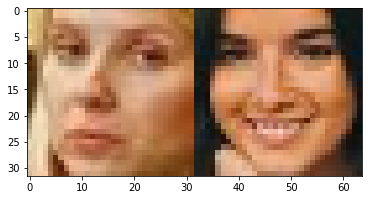

In [861]:
idx = randrange(train_dataset.__len__())
sample = train_dataset.__getitem__(idx)
show_example_with_prediction(sample)


#### Test Dataset

Wrong!
Positive Example Prediction: 0.3097446


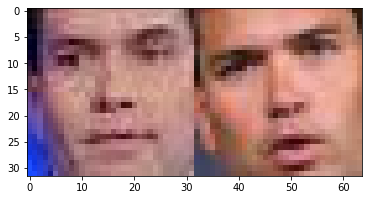

In [860]:
idx = randrange(test_dataset.__len__())
sample = test_dataset.__getitem__(idx)
show_example_with_prediction(sample)

## TODO
-Try to fix output layer
-Test other optimization functions
-Impliment average accuracy function
-format images better for ml

In [661]:
rands = [np.random.randn(1)[0]]


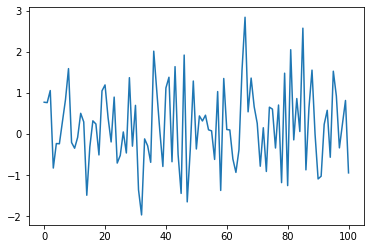

In [663]:
fig, ax = plt.subplots(1,1)
ax.plot(rands)
plt.show()
for i in range(100):
    rands.append(np.random.randn(1)[0])
    ax.plot(rands)
    fig.canvas.draw()
#     plt.pause(0.1)
# print(rands)

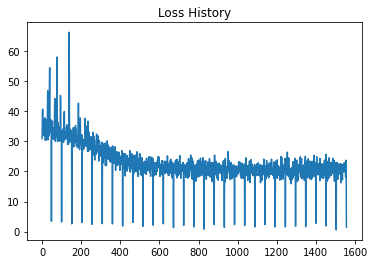

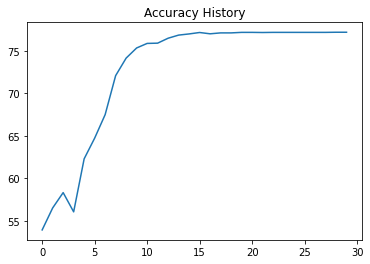

In [778]:
plt.title('Loss History')
plt.plot(loss_hist[3:])
plt.show()
plt.title('Accuracy History')
plt.plot(accuracy_on_train_hist)
plt.show()
